In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_test, y_train, y_test = mnist_prep()

# EnKF

In [5]:
batch_size = 600     # len(X_train)
epochs = 20
particles = 100
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [6]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [7]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [8]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [9]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [10]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [11]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

313/313 [==============================] - 0s 576us/step - loss: 2.3032 - accuracy: 0.0958


In [12]:
import time
start_time = time.time()

In [13]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)  
        
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    print("Training Accuracy after Epoch {}: {}".format(str(epoch+1), str(np.round(mean_model_train_acc[-1], 3))))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

Training Accuracy after Epoch 1: 0.365
Training Accuracy after Epoch 2: 0.388
Training Accuracy after Epoch 3: 0.398
Training Accuracy after Epoch 4: 0.403
Training Accuracy after Epoch 5: 0.407
Training Accuracy after Epoch 6: 0.409
Training Accuracy after Epoch 7: 0.411
Training Accuracy after Epoch 8: 0.413
Training Accuracy after Epoch 9: 0.415
Training Accuracy after Epoch 10: 0.416
Training Accuracy after Epoch 11: 0.418
Training Accuracy after Epoch 12: 0.419
Training Accuracy after Epoch 13: 0.42
Training Accuracy after Epoch 14: 0.422
Training Accuracy after Epoch 15: 0.422
Training Accuracy after Epoch 16: 0.423
Training Accuracy after Epoch 17: 0.424
Training Accuracy after Epoch 18: 0.425
Training Accuracy after Epoch 19: 0.426
Training Accuracy after Epoch 20: 0.426


In [14]:
end_time = time.time()
print("Calculation time: {} minutes.".format((end_time - start_time) / 60))

Calculation time: 117.39613665342331 minutes.


In [15]:
y_pred_dict["model_1"]

array([[3.8933817e-01, 8.9266226e-03, 1.9204859e-02, ..., 4.2164166e-04,
        3.2913547e-03, 3.5487872e-02],
       [5.2517992e-03, 2.5233296e-01, 9.9965461e-02, ..., 5.6514200e-02,
        1.7748120e-01, 2.3412810e-01],
       [6.8772053e-03, 4.3088745e-02, 1.1298989e-01, ..., 2.6253858e-01,
        1.3984779e-01, 6.9642924e-02],
       ...,
       [6.9220014e-02, 1.1737930e-02, 8.6614497e-02, ..., 3.7483910e-01,
        6.1336383e-02, 2.5948368e-02],
       [4.7984868e-01, 8.9095108e-04, 9.5122410e-03, ..., 1.9809527e-03,
        1.0319337e-03, 3.6383465e-02],
       [5.4720003e-02, 8.4556704e-03, 8.3442204e-02, ..., 3.5855449e-03,
        9.7540677e-02, 3.0770287e-01]], dtype=float32)

In [16]:
jacobian_dict["model_1"]

array([[-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       , ..., -0.       , -5.4800167,
        -0.       ],
       [-0.       , -0.       , -0.       , ..., -3.7377787, -0.       ,
        -0.       ],
       ...,
       [-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ],
       [-2.0624993, -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       , ..., -0.       , -0.       ,
        -0.       ]], dtype=float32)

In [17]:
print(np.round(mean_model_train_acc, 3))
print(np.round(mean_model_test_acc, 3))

[0.099 0.365 0.388 0.398 0.403 0.407 0.409 0.411 0.413 0.415 0.416 0.418
 0.419 0.42  0.422 0.422 0.423 0.424 0.425 0.426 0.426]
[0.096 0.371 0.391 0.399 0.403 0.406 0.407 0.409 0.411 0.412 0.415 0.417
 0.419 0.42  0.423 0.423 0.425 0.426 0.427 0.429 0.43 ]


In [18]:
train_acc_dict

{'model_1': [0.36434999108314514,
  0.3880166709423065,
  0.39836665987968445,
  0.4031166732311249,
  0.40701666474342346,
  0.40878334641456604,
  0.4111666679382324,
  0.41313332319259644,
  0.41475000977516174,
  0.416049987077713,
  0.41743332147598267,
  0.41894999146461487,
  0.4199333190917969,
  0.42160001397132874,
  0.42250001430511475,
  0.4233666658401489,
  0.4241666793823242,
  0.4248499870300293,
  0.4255833327770233,
  0.42633333802223206],
 'model_2': [0.36344999074935913,
  0.38803333044052124,
  0.39791667461395264,
  0.40345001220703125,
  0.40665000677108765,
  0.4086500108242035,
  0.4109666645526886,
  0.4128166735172272,
  0.41456666588783264,
  0.41616666316986084,
  0.4175499975681305,
  0.4186500012874603,
  0.42034998536109924,
  0.4215833246707916,
  0.4223666787147522,
  0.4234166741371155,
  0.4242333471775055,
  0.4247666597366333,
  0.4255000054836273,
  0.42625001072883606],
 'model_3': [0.36250001192092896,
  0.3880833387374878,
  0.3979666531085968,

In [19]:
test_acc_dict

{'model_1': [0.37209999561309814,
  0.390500009059906,
  0.39959999918937683,
  0.40470001101493835,
  0.40540000796318054,
  0.40700000524520874,
  0.4081999957561493,
  0.4108999967575073,
  0.41260001063346863,
  0.41530001163482666,
  0.41690000891685486,
  0.4185999929904938,
  0.4196999967098236,
  0.42170000076293945,
  0.42309999465942383,
  0.424699991941452,
  0.4253999888896942,
  0.4268999993801117,
  0.42879998683929443,
  0.42969998717308044],
 'model_2': [0.3711000084877014,
  0.3912000060081482,
  0.39910000562667847,
  0.4036000072956085,
  0.4050000011920929,
  0.4068000018596649,
  0.40959998965263367,
  0.41019999980926514,
  0.4124000072479248,
  0.4146000146865845,
  0.4172999858856201,
  0.4189000129699707,
  0.41990000009536743,
  0.421999990940094,
  0.42309999465942383,
  0.424699991941452,
  0.4255000054836273,
  0.4269999861717224,
  0.42879998683929443,
  0.42969998717308044],
 'model_3': [0.3709000051021576,
  0.39070001244544983,
  0.39899998903274536,
  

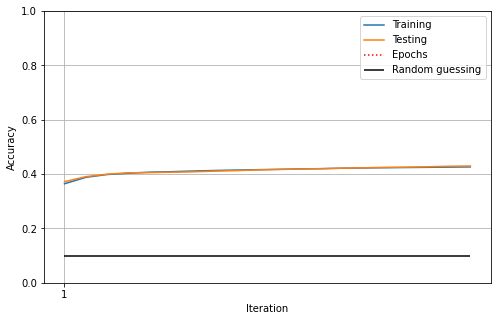

In [20]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

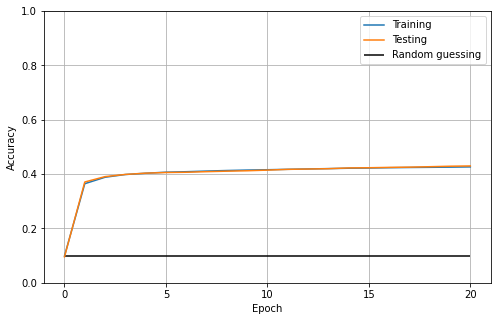

In [21]:
nn_plot_epoch_acc(mean_model_train_acc,
                  mean_model_test_acc,
                  mean_comparison = 0.1,
                  savefig = True,
                  file = "../img/enkf_model_mnist_full_E{}_B{}_P{}_H{}.png".format(epochs, batch_size, particles, h_0))

In [22]:
nn_save(mean_model, 
        "../models/enkf_model_mnist_full_E{}_B{}_P{}_H{}.h5".format(epochs, batch_size, particles, h_0))